# Deep Learning Featured Model Training

In [1]:
import sys
sys.path.insert(0, '../../')
from library.notebook_api.deep_learning_training_data import get_feature_vector_data
from library.notebook_api.deep_learning_models import  get_2d_cnn
from library.notebook_api.model_evaluation import plot_training_history, ModelEvaluation
from configuration import SAVED_MODEL_PATH
from tensorflow import keras
import numpy as np

2024-12-08 06:59:30.581509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Scenario 1: Using MFCC 13X500 feature vector

In [2]:
#sketch of augmentation

#based on shape of initial row, and provided segment numbers and overlaps produce array of in and out locations
def get_augmented_segment_boundaries(train_row, num_segments=6, overlap_factor=.2 ):
    full_duration = train_row.shape[0]
    
    equivalized_exact_duration_whole = int(full_duration/num_segments)

    remnant_after_rounding = full_duration - (equivalized_exact_duration_whole *num_segments)

    base_duration_array = [equivalized_exact_duration_whole for index in list(range(0,num_segments)) ]

    padded_duration_array = [int(duration * (1 + overlap_factor)) for duration in base_duration_array]
    start_frame = 0
    end_frame = 0
    segment_boundaries = []
    for index, duration in enumerate(base_duration_array):
        segment_boundary = []
        if index != (num_segments -1):
            end_frame = start_frame + padded_duration_array[index]
        else:
            end_frame = full_duration - 1
            start_frame = end_frame - padded_duration_array[index]
        segment_boundary.append(start_frame)
        segment_boundary.append(end_frame)
        segment_boundaries.append(segment_boundary)
        start_frame += base_duration_array[index]

        #print(index, duration)
    return segment_boundaries


def get_augmented_x_y( X,y, num_segments=8, overlap_factor=.3):
    segment_boundaries = get_augmented_segment_boundaries(X[0],num_segments, overlap_factor)
    print("creating augmented data with segment boundaries", segment_boundaries)

    #for oversampling minority
    y_flattened = np.argmax(y,axis=1)
    _, counts = np.unique(y_flattened,return_counts=True)
    #instantiate probability of each label
    label_weights = counts / np.sum(counts)
    inv_label_weights = 1 - label_weights
    print(inv_label_weights)

    augmented_X=[]
    augmented_y = []
    for index, train_row in enumerate(X):
        row_sample_weight = inv_label_weights[y_flattened[index]]
        if row_sample_weight > .9:
            row_sample_weight = 1
        else:
            row_sample_weight = row_sample_weight * .25
        for segment_boundary in segment_boundaries:
            if np.random.binomial(1, row_sample_weight) ==1:
            #if row_sample_weight > .8:
                augmented_X.append(train_row[segment_boundary[0]:segment_boundary[1]])
                augmented_y.append(y[index])
    return np.array(augmented_X), np.array(augmented_y)


In [25]:
X_train, X_test, y_train, y_test,label_encoder =get_feature_vector_data(vector_type = 'mfcc',
                                                        version_string = '006',
                                                        vector_length = 1000, 
                                                        apply_normalization = True,
                                                        apply_resampling=False)

Loading mfcc vectors
features shape distribution
1099    20865
1         221
293         2
173         2
862         2
392         1
467         1
201         1
946         1
622         1
Name: count, dtype: int64
total records:  21164
normalized length:  20871
Row Count after label based filter:  21164
Final Row count after label and feature filter:  20871
Unique label count:  6
label data count  20871
applying normaization


In [27]:
X_train, y_train = get_augmented_x_y(X_train, y_train)
X_test, y_test  = get_augmented_x_y(X_test, y_test)

creating augmented data with segment boundaries [[0, 162], [125, 287], [250, 412], [375, 537], [500, 662], [625, 787], [750, 912], [837, 999]]
[0.93705079 0.98592477 0.68501437 0.82672496 0.9679564  0.5973287 ]
creating augmented data with segment boundaries [[0, 162], [125, 287], [250, 412], [375, 537], [500, 662], [625, 787], [750, 912], [837, 999]]
[0.93700599 0.98586826 0.68502994 0.82682635 0.96790419 0.59736527]


In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22658, 162, 13, 1), (5722, 162, 13, 1), (22658, 6), (5722, 6))

In [29]:
np.unique(np.argmax(y_train,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([8408, 1880, 2938, 1927, 4280, 3225]))

In [ ]:
selected_hp = {'learning_rate':  0.0001}
#selected_hp = {'learning_rate':  0.001}

type(selected_hp)
model_1 = get_2d_cnn(selected_hp)


In [31]:
history = model_1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    
    #batch_size=32,
    #batch_size=64,
    batch_size = 128,
    epochs=200,
    #epochs = 50,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),

    ]
)

Epoch 1/200
178/178 [==============================] - 24s 121ms/step - loss: 1.7241 - accuracy: 0.3460 - val_loss: 1.8771 - val_accuracy: 0.1407
Epoch 2/200
178/178 [==============================] - 23s 128ms/step - loss: 1.4093 - accuracy: 0.4616 - val_loss: 2.0846 - val_accuracy: 0.2192
Epoch 3/200
178/178 [==============================] - 23s 128ms/step - loss: 1.3163 - accuracy: 0.4935 - val_loss: 1.6234 - val_accuracy: 0.3333
Epoch 4/200
178/178 [==============================] - 23s 130ms/step - loss: 1.2730 - accuracy: 0.5109 - val_loss: 1.2222 - val_accuracy: 0.5294
Epoch 5/200
178/178 [==============================] - 23s 129ms/step - loss: 1.2504 - accuracy: 0.5154 - val_loss: 1.2152 - val_accuracy: 0.5308
Epoch 6/200
178/178 [==============================] - 23s 129ms/step - loss: 1.2336 - accuracy: 0.5252 - val_loss: 1.1922 - val_accuracy: 0.5416
Epoch 7/200
178/178 [==============================] - 23s 129ms/step - loss: 1.2197 - accuracy: 0.5304 - val_loss: 1.1852 -

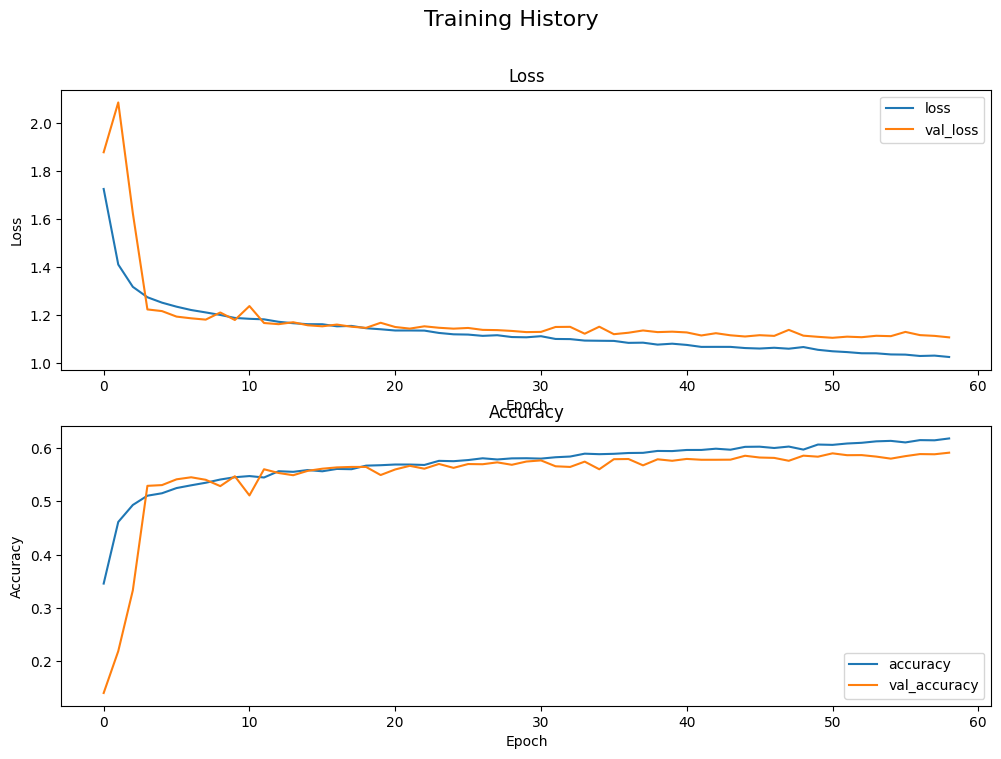

In [35]:
plot_training_history(history)

In [38]:
model_1_name = 'CNN_MFCC'
#model_1_file_name = 'v6b_mfcc_scaled_128_22500_500_cnn_2d_128_batch_50_epoch_lr_0001.keras'
#model_1_file_name = 'v6c_mfcc_scaled_resampled_128_22500_500_cnn_2d_128_batch_200_epoch_lr_0001.keras'
model_1_file_name = 'v6c_mfcc_scaled_segmentresampled625_128_22500_100_cnn_2d_128_batch_200_epoch_lr_0001.keras'


model_1.save(SAVED_MODEL_PATH+model_1_file_name)

AttributeError: 'ModelEvaluation' object has no attribute 'save'

179/179 [==============================] - 3s 14ms/step
179/179 - 2s - loss: 1.1039 - accuracy: 0.5904 - 2s/epoch - 13ms/step

Test Accuracy: 59.04%
Test Loss: 1.1039

Classification Report:
              precision    recall  f1-score   support

   classical       0.76      0.87      0.81      2104
     country       0.44      0.28      0.34       472
  electronic       0.51      0.42      0.46       734
      hiphop       0.60      0.60      0.60       499
        jazz       0.40      0.29      0.34      1072
        rock       0.44      0.60      0.51       841

    accuracy                           0.59      5722
   macro avg       0.53      0.51      0.51      5722
weighted avg       0.57      0.59      0.57      5722



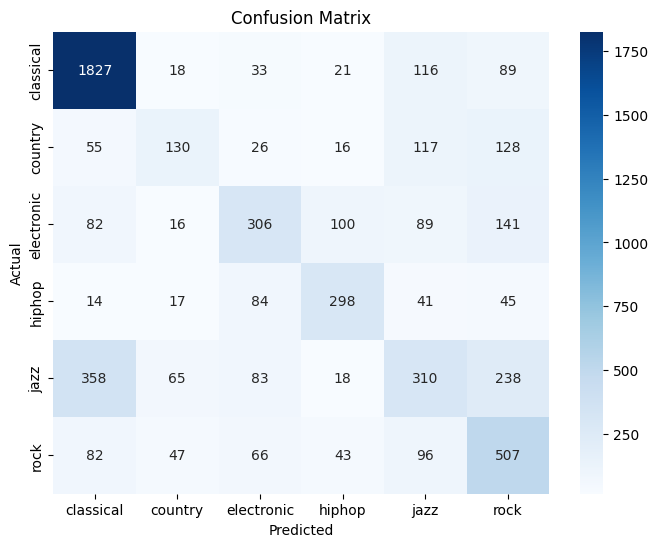

In [39]:
model_1 = ModelEvaluation(model_1_name,model_1_file_name,X_test, y_test, label_encoder)

94/94 [==============================] - 4s 39ms/step
94/94 - 4s - loss: 0.7806 - accuracy: 0.7214 - 4s/epoch - 44ms/step

Test Accuracy: 72.14%
Test Loss: 0.7806

Classification Report:
              precision    recall  f1-score   support

   classical       0.60      0.79      0.68       109
     country       0.17      0.22      0.19        59
  electronic       0.71      0.70      0.70       909
      hiphop       0.37      0.66      0.47       117
        jazz       0.23      0.45      0.30       106
        rock       0.89      0.77      0.82      1686

    accuracy                           0.72      2986
   macro avg       0.49      0.60      0.53      2986
weighted avg       0.77      0.72      0.74      2986



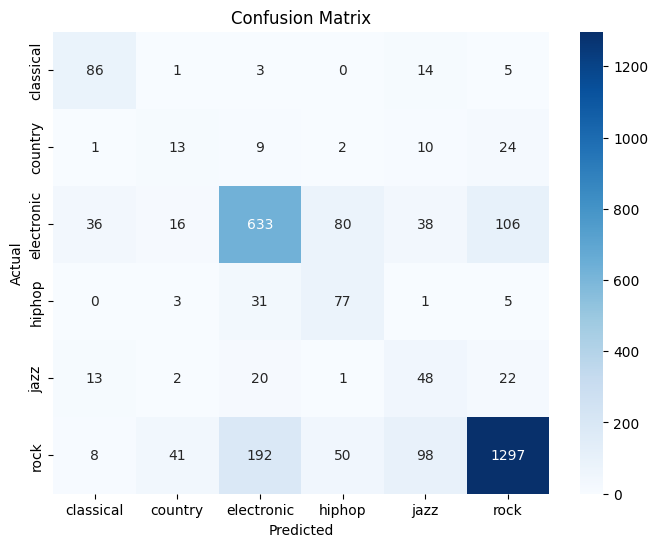

In [9]:
model_1 = ModelEvaluation(model_1_name,model_1_file_name,X_test, y_test, label_encoder)

69/69 [==============================] - 3s 38ms/step
69/69 - 3s - loss: 0.6689 - accuracy: 0.7619 - 3s/epoch - 38ms/step

Test Accuracy: 76.19%
Test Loss: 0.6689

Classification Report:
              precision    recall  f1-score   support

   classical       0.83      0.78      0.81       109
     country       0.75      0.05      0.10        59
  electronic       0.75      0.78      0.77       733
      hiphop       0.75      0.42      0.54       117
        jazz       0.47      0.23      0.31       106
        rock       0.78      0.88      0.82      1073

    accuracy                           0.76      2197
   macro avg       0.72      0.52      0.56      2197
weighted avg       0.75      0.76      0.74      2197



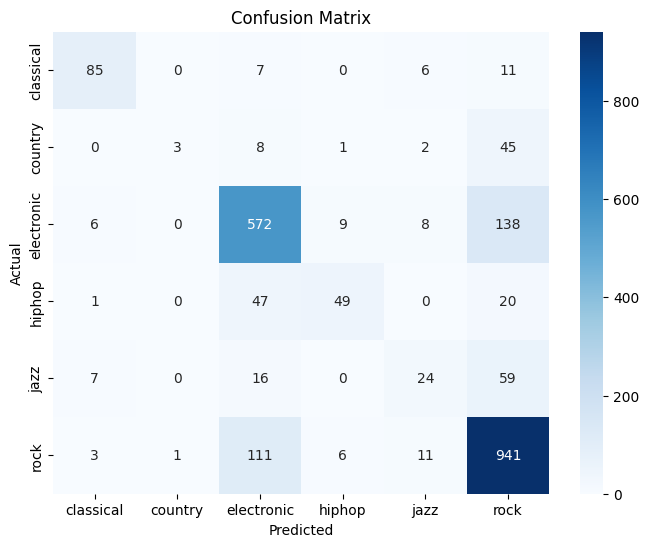

In [ ]:
#6b
model_1 = ModelEvaluation(model_1_name,model_1_file_name,X_test, y_test, label_encoder)

## Scenario 2: Using Log MelSepctrogram 128X500 feature vector

to do: memory profile training data

In [3]:
X_train_, X_test_, y_train_, y_test_,label_encoder =get_feature_vector_data(vector_type = 'log_mel',
                                                        version_string = '006',
                                                        vector_length = 1000, 
                                                        apply_normalization = True)

Loading log mel vectors


KeyboardInterrupt: 

In [ ]:
X_train_.shape, X_test_.shape, y_train_.shape, y_test_.shape

(TensorShape([16708, 800, 128, 1]),
 TensorShape([4177, 800, 128, 1]),
 (16708, 6),
 (4177, 6))

In [ ]:
np.unique(np.argmax(y_train_,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([1051,  235, 5259, 2895,  535, 6733]))

In [ ]:
X_train, y_train = get_augmented_x_y(X_train_, y_train_,num_segments=4, overlap_factor=.3)
X_test, y_test  = get_augmented_x_y(X_test_, y_test_,num_segments=4, overlap_factor=.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


creating augmented data with segment boundaries [[0, 130], [100, 230], [200, 330], [300, 430], [400, 530], [500, 630], [600, 730], [669, 799]]
[0.937096   0.98593488 0.6852406  0.82672971 0.96797941 0.59701939]
creating augmented data with segment boundaries [[0, 130], [100, 230], [200, 330], [300, 430], [400, 530], [500, 630], [600, 730], [669, 799]]
[0.93703615 0.98587503 0.68518075 0.82690927 0.96791956 0.59707924]


((22683, 130, 128, 1), (5738, 130, 128, 1), (22683, 6), (5738, 6))

In [7]:
np.unique(np.argmax(y_train,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([8408, 1880, 2890, 1869, 4280, 3356]))

In [8]:
selected_hp = {'learning_rate':  0.0001}
#selected_hp = {'learning_rate':  0.001}

type(selected_hp)
model_2 = get_2d_cnn(selected_hp)

In [9]:
history = model_2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    
    #batch_size=32,
    #batch_size=64,
    batch_size = 128,
    #epochs=200,
    epochs = 200,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),

    ]
)

Epoch 1/200
178/178 [==============================] - 172s 953ms/step - loss: 1.4859 - accuracy: 0.4599 - val_loss: 2.9357 - val_accuracy: 0.3743
Epoch 2/200
178/178 [==============================] - 167s 939ms/step - loss: 1.2416 - accuracy: 0.5419 - val_loss: 2.3492 - val_accuracy: 0.4416
Epoch 3/200
178/178 [==============================] - 160s 901ms/step - loss: 1.1711 - accuracy: 0.5693 - val_loss: 1.2645 - val_accuracy: 0.5525
Epoch 4/200
178/178 [==============================] - 158s 886ms/step - loss: 1.0999 - accuracy: 0.5945 - val_loss: 1.1270 - val_accuracy: 0.5917
Epoch 5/200
178/178 [==============================] - 157s 883ms/step - loss: 1.0405 - accuracy: 0.6195 - val_loss: 1.1247 - val_accuracy: 0.5878
Epoch 6/200
178/178 [==============================] - 159s 896ms/step - loss: 0.9993 - accuracy: 0.6335 - val_loss: 1.1081 - val_accuracy: 0.5993
Epoch 7/200
178/178 [==============================] - 158s 890ms/step - loss: 0.9510 - accuracy: 0.6565 - val_loss: 1

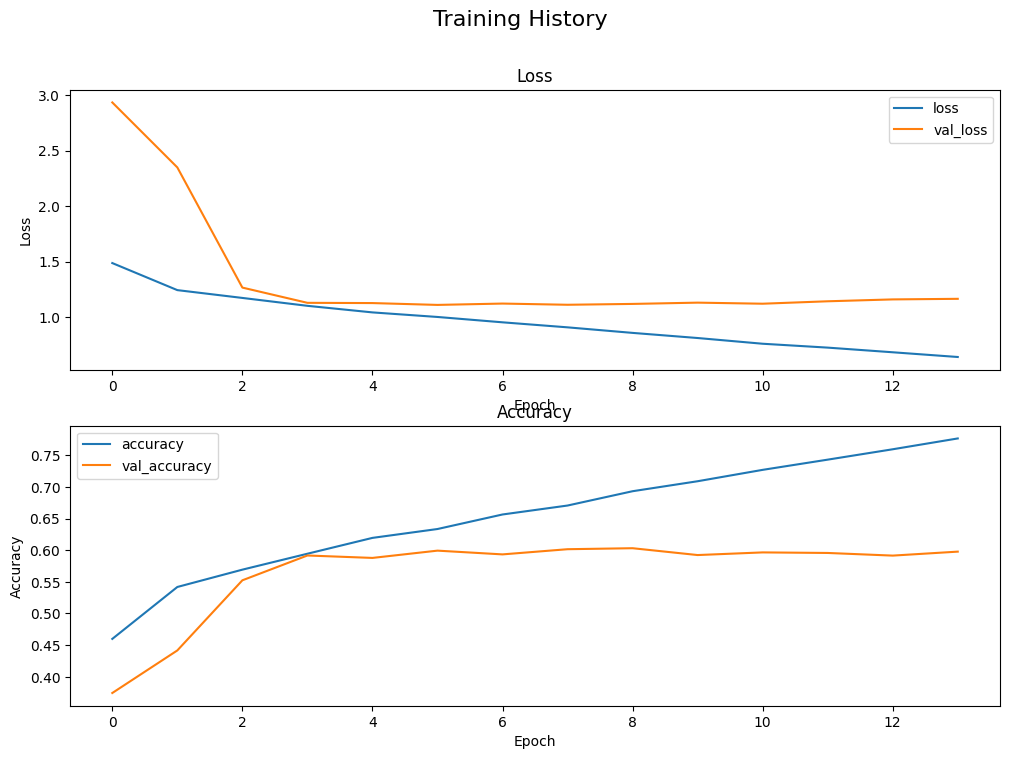

In [10]:
plot_training_history(history)

In [11]:
model_2_name = 'CNN_LogMel'
#model_2_file_name = 'v6b_logmel_scaled_128_22500_500_cnn_2d_128_batch_18_epoch_lr_0001.keras'
model_2_file_name = 'v6c_logmel_scaled_resampledsegment625_128_22500_1000_cnn_2d_128_batch_18_epoch_lr_0001.keras'

model_2.save(SAVED_MODEL_PATH+model_2_file_name)

180/180 [==============================] - 14s 78ms/step
180/180 - 14s - loss: 1.1081 - accuracy: 0.5993 - 14s/epoch - 78ms/step

Test Accuracy: 59.93%
Test Loss: 1.1081

Classification Report:
              precision    recall  f1-score   support

   classical       0.74      0.88      0.80      2104
     country       0.33      0.21      0.26       472
  electronic       0.54      0.42      0.47       753
      hiphop       0.50      0.53      0.52       465
        jazz       0.45      0.34      0.39      1072
        rock       0.53      0.64      0.58       872

    accuracy                           0.60      5738
   macro avg       0.52      0.50      0.50      5738
weighted avg       0.58      0.60      0.58      5738



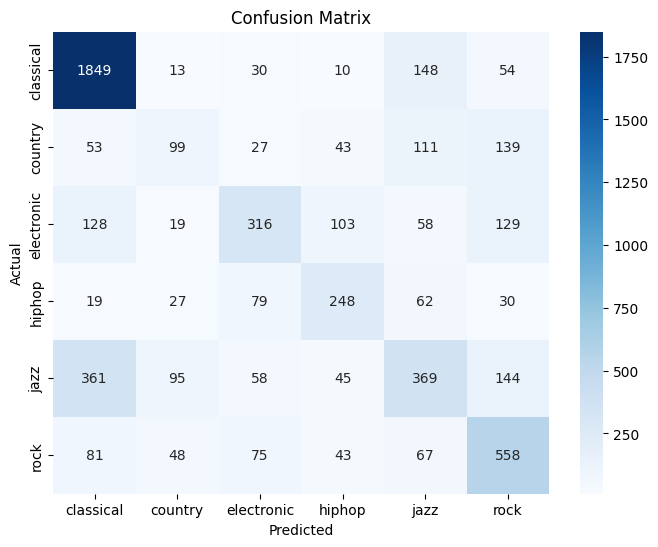

In [12]:
model_2 = ModelEvaluation(model_2_name,model_2_file_name,X_test, y_test, label_encoder)


69/69 [==============================] - 26s 373ms/step
69/69 - 22s - loss: 0.7576 - accuracy: 0.7679 - 22s/epoch - 317ms/step

Test Accuracy: 76.79%
Test Loss: 0.7576

Classification Report:
              precision    recall  f1-score   support

   classical       0.77      0.62      0.69       109
     country       0.45      0.08      0.14        59
  electronic       0.74      0.82      0.78       733
      hiphop       0.75      0.42      0.54       117
        jazz       0.43      0.21      0.28       106
        rock       0.80      0.88      0.84      1073

    accuracy                           0.77      2197
   macro avg       0.66      0.51      0.54      2197
weighted avg       0.75      0.77      0.75      2197



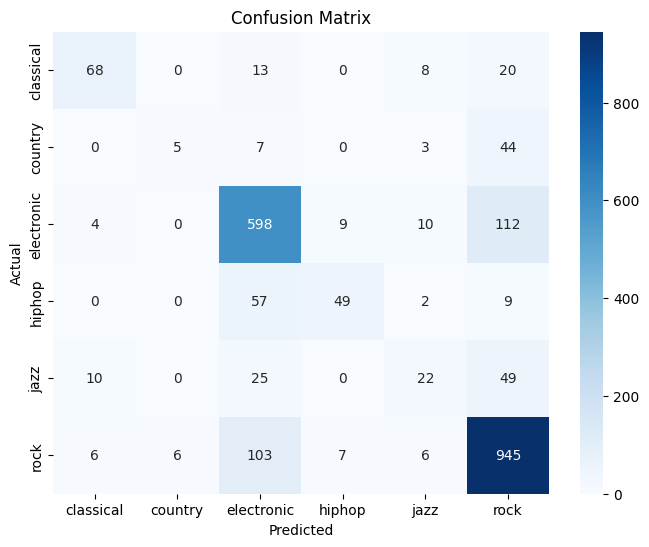

In [7]:
model_2 = ModelEvaluation(model_2_name,model_2_file_name,X_test, y_test, label_encoder)
#model_2 = ModelEvaluation(model_2_file_name,X_test, y_test, label_encoder)

## Comparative Analysis

In [8]:
import pandas as pd
import altair as alt
alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [ ]:
def get_model_evaluation_comparison_data(model_evals, metrics):
    comparison_dfs = {}
    for metric in metrics:
        metric_model_array = []
        for model in model_evals:
            metric_model_array.append(pd.DataFrame(model.classification_report).T[metric])

        comparison_dfs[metric] = pd.concat(metric_model_array, axis=1)
        comparison_dfs[metric].columns = [model.name for model in model_evals]
        comparison_dfs[metric] = comparison_dfs[metric].T
        comparison_dfs[metric].reset_index(inplace=True)
    return comparison_dfs


In [ ]:
metrics = ['precision', 'recall','f1-score']
model_evals = [model_1, model_2]
genres =  model_evals[0].label_encoder.classes_
comparison_dfs = get_model_evaluation_comparison_data(model_evals,metrics)


In [24]:
 alt.Chart(comparison_dfs['precision']).mark_bar().encode(
        x=alt.X('amount:Q', title=None),
        y=alt.Y('type:N', title=None),
        color=alt.Color('amount:Q', legend=None),
        column=alt.Column('index',
                        title=None)).transform_fold(as_=['type', 'amount'],
                                                    fold=genres).properties(
                                                        width=100,
                                                        title=f'Precision by Model')



alt.Chart(...)

In [25]:
 alt.Chart(comparison_dfs['recall']).mark_bar().encode(
        x=alt.X('amount:Q', title=None),
        y=alt.Y('type:N', title=None),
        color=alt.Color('amount:Q', legend=None),
        column=alt.Column('index',
                        title=None)).transform_fold(as_=['type', 'amount'],
                                                    fold=genres).properties(
                                                        width=100,
                                                        title=f'Recall by Model')

alt.Chart(...)

In [26]:
 alt.Chart(comparison_dfs['f1-score']).mark_bar().encode(
        x=alt.X('amount:Q', title=None),
        y=alt.Y('type:N', title=None),
        color=alt.Color('amount:Q', legend=None),
        column=alt.Column('index',
                        title=None)).transform_fold(as_=['type', 'amount'],
                                                    fold=genres).properties(
                                                        width=100,
                                                        title=f'F1 Score by Model')

alt.Chart(...)


#https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive.
Precision is a good measure to determine, when the costs of False Positive is high. For instance, email spam detection

Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.


f1 = 2 x( (precions*recall)/(recision+recal))

F1 Score is needed when you want to seek a balance between Precision and Recall. Right…so what is the difference between F1 Score and Accuracy then? We have previously seen that accuracy can be largely contributed by a large number of True Negatives which in most business circumstances, we do not focus on much whereas False Negative and False Positive usually has business costs (tangible & intangible) thus F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).



Next Notes: 
xProduce evaluation images and data points for each of the two models, through finishing evaluation functions

xLeft off finishing model evaluation

x-next up:
put it in external file.  

Consider , having separate evaluation specific notebook to include more of the summary insights , whereas this notebook can have the training. 





Create a model eval comparison visual leveraging tetyana's code 
comparative image goes in report describing and comparing the two scenarios vs. tetyana's, and talking about what it took ( cost side)

retrain models in featured notebook, and resave (do more epochs)
Consider approach for parameter tuning 
consider whether to supply validation data from test set OR not (may be incorect )


See if can make the confusion matrix align in order to tetyanas for comparability
